## Initialization

In [1]:
universityStorage = True

In [2]:
guy_folder = "/vol/scratch/guy" if universityStorage else "/content"

### pip

In [9]:
%pip install matplotlib seaborn pandas tqdm tensorboard

Note: you may need to restart the kernel to use updated packages.


### PyTorch + Transformers

In [20]:
%cd {guy_folder}
!mkdir torch-transformers-cache

/specific/scratches/scratch/guy
mkdir: cannot create directory 'torch-transformers-cache': File exists


In [13]:
%cd {guy_folder}
!mkdir datasets
!mkdir torch-transformers-cache

%pip install --no-cache-dir torch==1.4.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

%cd {guy_folder}/torch-transformers-cache/
!git clone https://github.com/huggingface/transformers.git
%pip install ./transformers
%pip install -U nlp

%cd {guy_folder}
## Not working!!!
!setenv TRANSFORMERS_CACHE /vol/scratch/guy/torch-transformers-cache
!setenv CUDA_VISIBLE_DEVICES 0

/specific/scratches/scratch/guy
mkdir: cannot create directory 'torch-transformers-cache': File exists
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.
/specific/scratches/scratch/guy/torch-transformers-cache
Cloning into 'transformers'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 38349 (delta 9), reused 9 (delta 2), pack-reused 38326
Receiving objects: 100% (38349/38349), 27.73 MiB | 5.96 MiB/s, done.
Resolving deltas: 100% (26573/26573), done.
Checking connectivity... done.
Checking out files: 100% (1014/1014), done.
Processing ./transformers
  Using cached tokenizers-0.8.1rc2-cp38-cp38-manylinux1_x86_64.whl (3.0 MB)
  Using cached packaging-20.4-py2.py3-none-any.whl (37 kB)
  Using cached filelock-3.0.12-py3-none-any.whl (7.6 kB)
  Using cached regex-2020.7.14-cp38-cp38-manylinux2010_x86_64.whl

#### Update Transformers

In [ ]:
%cd {guy_folder}/torch-transformers-cache/transformers
!git pull
%pip install -e .

/specific/scratches/scratch/guy/torch-transformers-cache/transformers
Already up-to-date.
Obtaining file:///specific/scratches/scratch/guy/torch-transformers-cache/transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformers-3.0.2
  Running setup.py develop for transformers
Note: you may need to restart the kernel to use updated packages.


### Get dataset

In [14]:
%cd {guy_folder}/datasets
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf acl*.tar.gz
%cd {guy_folder}

/specific/scratches/scratch/guy/datasets
--2020-08-16 12:54:47--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: 'aclImdb_v1.tar.gz'

100%[======================================>] 84,125,825  1.04MB/s   in 97s    

2020-08-16 12:56:25 (847 KB/s) - 'aclImdb_v1.tar.gz' saved [84125825/84125825]

/specific/scratches/scratch/guy


### import

In [3]:
cache_dir = guy_folder + "/torch-transformers-cache/"
import torch
from tokenizers import Tokenizer
import transformers
from transformers import AutoModel, AutoTokenizer, pipeline
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import re, pdb
import itertools
%matplotlib inline
%cd {guy_folder}/datasets


/specific/scratches/scratch/guy/datasets


### Load dataset

In [16]:
%cd {guy_folder}
!mkdir datasets

/specific/scratches/scratch/guy
mkdir: cannot create directory 'datasets': File exists


In [4]:
import glob
sentences = []
target = []
path =  guy_folder + '/datasets/aclImdb/train/**/*.txt' 
files = glob.glob(path)
for name in tqdm(files):
    with open(name) as f:
        target+=[int('pos' in name)] # Classical quick & dirty
        sentences += [l for l in f]

100%|██████████| 75000/75000 [02:32<00:00, 491.67it/s]


## Transformers Initialization 

### Load

In [18]:
padding = False

In [5]:
if ('padding' not in globals()) and ('padding' not in locals()):
    padding = False
from transformers import BertTokenizerFast, GPT2TokenizerFast, RobertaTokenizerFast
device = 'cpu'
bertTokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', output_attentions = True,  cache_dir = cache_dir)
bertModel = AutoModel.from_pretrained('bert-base-uncased', output_attentions = True, cache_dir = cache_dir)

robertaTokenizer = RobertaTokenizerFast.from_pretrained('roberta-base',   output_attentions = True, cache_dir = cache_dir)
robertaModel = AutoModel.from_pretrained('roberta-base',   output_attentions = True, cache_dir = cache_dir)

gptModel = AutoModel.from_pretrained('gpt2',   output_attentions = True, cache_dir = cache_dir)

if padding:
    gptTokenizer = GPT2TokenizerFast.from_pretrained('gpt2',   output_attentions = True, cache_dir = cache_dir, pad_token = '<PAD>')    
else:
    gptTokenizer = GPT2TokenizerFast.from_pretrained('gpt2',   output_attentions = True, cache_dir = cache_dir)#, pad_token = '<PAD>')

bertModel=bertModel.to(device)
gptModel=gptModel.to(device)
if padding:
    gptModel.resize_token_embeddings(len(gptTokenizer))

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def _getAttentionsReshaped(outputs, wordsToTokens = None, layerwise = False, reshape = True):
    attentions_ = outputs[-1]#.attentions # (n_layers, batch, n_heads, N, N) TODO: Verify!
    attentions = torch.stack(attentions_).permute(0, 2, 1, 3, 4)
    if wordsToTokens is not None:
        shape = (attentions.size(0), attentions.size(1), -1) if layerwise else (attentions.size(0) * attentions.size(1), -1)
        attentions = _combineTokensByWords(attentions, wordsToTokens)
        assert((abs(attentions.sum(axis = -1) - 1) < 0.1).all())
        if reshape:
          attentions = attentions.reshape(*shape)
    else:
        if reshape:
          attentions = attentions.reshape(attentions.size(0) * attentions.size(1), -1, attentions.size(-1))
    if not reshape:
        attentions = torch.squeeze(attentions)
    return attentions


In [7]:
def _combineTokensByWords(attentions, wordsToTokens): # Both rows & columns
        nTokens = sum(wordsToTokens)
        nWords = len(wordsToTokens)
        s = np.zeros((nTokens, nWords))
        weights = sum([[1./a] * a for a in wordsToTokens], [])
        wordNum = sum([[i]*a for i, a in enumerate(wordsToTokens)], [])
        s[list(range(nTokens)), wordNum] = weights
        s = torch.FloatTensor(s)
        return s.T @ attentions @ s

def _wordsToTokensByOffset(sent, offsets): # Not gonna document this 
    wordOffsets = [-1]+list(map(lambda x: x.span()[0], (re.finditer(r'\s+', sent))))+[len(sent)+1]
    offsets = list(map(lambda x: x[0], offsets)) 
    zWords = list(zip(wordOffsets, itertools.repeat("word")))
    zTokens = list(zip(offsets, itertools.repeat("token")))
    s = sorted(itertools.chain(zWords, zTokens), key = lambda x: x[0])
    lensArr = np.diff([i for i, a in enumerate(s) if a[1] == 'word'])-1
    return lensArr


def tokenizeSentencesNoPadding(tokenizers, sentences):
    output = []
    modelsWordsToTokens = []
    for tokenizer in tokenizers:
        output += [[]]
        modelsWordsToTokens += [[]]
        print(tokenizer.__class__)
        for sent in tqdm(sentences):
            tokenized_sent = tokenizer(sent, pad_to_max_length = False, max_length=60, return_tensors='pt', 
                                       return_offsets_mapping = True,
                                       truncation = True)
            
            tokenOffsets = (tokenized_sent.pop('offset_mapping').numpy()[0]).tolist() #TODO: Make sure the 0-index does the right thing
            modelsWordsToTokens[-1]+=[ _wordsToTokensByOffset(sent, tokenOffsets) ]
            output[-1]+=[ tokenized_sent]
    return zip(output, modelsWordsToTokens)

In [8]:
num_sentences = 100
((bertEncoded, bertWordsToTokens), 
     (gptEncoded, gptWordsToTokens), 
     (robertaEncoded, robertaWordsToTokens)) = tokenizeSentencesNoPadding((bertTokenizer, gptTokenizer, robertaTokenizer),
                                                                       sentences[:num_sentences])



 18%|█▊        | 18/100 [00:00<00:00, 176.62it/s]

<class 'transformers.tokenization_bert.BertTokenizerFast'>


 16%|█▌        | 16/100 [00:00<00:00, 154.18it/s]

<class 'transformers.tokenization_gpt2.GPT2TokenizerFast'>


 22%|██▏       | 22/100 [00:00<00:00, 186.84it/s]

<class 'transformers.tokenization_roberta.RobertaTokenizerFast'>


100%|██████████| 100/100 [00:00<00:00, 233.79it/s]


In [9]:
def headSimilarityNoPadding(modelA, modelB, encodedA_list, encodedB_list, 
                                           wordsToTokensA_list, wordsToTokensB_list):
    res = None
    for (encodedA, encodedB, wordsToTokensA, wordsToTokensB) in tqdm(
                                        zip(encodedA_list, encodedB_list,
                                          wordsToTokensA_list, wordsToTokensB_list), total = len(encodedA_list)):

        N = len(wordsToTokensA) # TODO: Fix N to the right formula
        attentionsA = _getAttentionsReshaped(modelA(**encodedA), wordsToTokens = wordsToTokensA).detach().numpy()
        attentionsB = _getAttentionsReshaped(modelB(**encodedB), wordsToTokens = wordsToTokensB).detach().numpy() 
        
        new_res = klDivAllPairs(attentionsA, attentionsB, N)
        if res is None:
            res = new_res
        else:
            res += new_res
    
    return res/len(encodedA_list)

## Get "clean" attention heads

In [135]:
def cleanseAttentions(att):
    att_ = att.clone()
    mymax = att.max(axis = -1)[0].unsqueeze(-1)
    threshold = mymax * .25
    att_[att < threshold] = 0
    att_[att >= threshold] = 1
    return att_

In [10]:
(modelA, modelB, encodedA_list, encodedB_list, 
            wordsToTokensA_list, wordsToTokensB_list) = (bertModel, gptModel, bertEncoded, gptEncoded, 
                                  bertWordsToTokens, gptWordsToTokens)


In [194]:
def goodAttention(attentionsA):
  return ((attentionsA.topk(5, axis = -1)[0].sum(axis =-1, keepdims = False ) > 0.7)
         & (attentionsA.topk(2, axis = -1)[0].sum(axis =-1, keepdims = False ) < 0.7)
  ).type('torch.FloatTensor')
  # (cleanseAttentions(attentionsA)
  #                 .topk(3, axis = -1)[0].sum(axis =-1, keepdims = False ) > 0.5).type('torch.FloatTensor')

In [204]:
from tqdm import tqdm_notebook
nSamples = len(encodedA_list)
s = torch.zeros((24,16))
with torch.no_grad():
  for (encodedA, wordsToTokensA) in tqdm_notebook(
                                          zip(encodedA_list, wordsToTokensA_list), total = len(encodedA_list)):
          
          N = len(wordsToTokensA) # TODO: Fix N to the right formula
          attentionsA = _getAttentionsReshaped(largeBertModel(**encodedA), 
                                               wordsToTokens = None, 
                                               reshape = False)
          curS = (goodAttention(attentionsA)
                  .mean(axis = -1, keepdims = False))
          s += curS
                  
s = s/nSamples

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


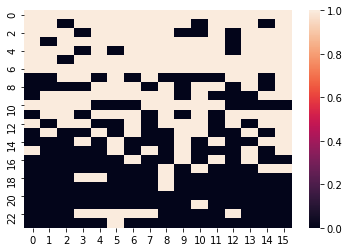

In [207]:
sns.heatmap(s < 0.25)

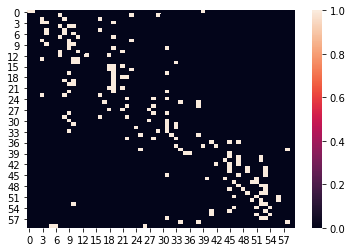

In [263]:
layer =  11
head =  10


x = attentionsA[layer, head]
a = []
y = x.topk(3, axis = 0)[1].tolist()
for y_ in y:
  a+=list(enumerate(y_))

z = torch.zeros(*x.shape)
for a_ in a:
  z[a_] = 1
sns.heatmap(z) # Why axis = -1 is not the right one


In [193]:
pd.DataFrame(s.numpy())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.013750,0.860000,0.968333,0.016917,0.036750,0.014417,0.000750,0.001500,0.009000,0.982332,0.080000
1,0.065333,0.980916,0.081167,0.069333,0.982916,0.187833,1.000000,0.044583,0.013417,0.019417,0.370500,0.269583
2,1.000000,0.960000,0.730750,0.110750,0.328500,0.144333,0.698167,0.117833,0.249667,1.000000,0.258833,0.210917
3,0.979000,0.073250,0.445333,0.836583,0.247000,1.000000,0.216167,0.177667,0.201167,0.999667,0.466417,0.960083
4,0.511417,0.041583,0.520833,0.996000,0.138500,0.964250,0.535167,0.998000,0.681583,0.184167,0.811750,0.985999
5,0.980667,1.000000,0.274250,0.798666,0.162250,0.936000,0.999833,0.980666,0.572833,0.999833,0.997500,0.969000
6,0.875250,0.718917,0.902250,1.000000,0.967917,0.922250,0.993666,0.153083,0.768000,0.990000,0.984000,0.999833
7,0.764000,0.901667,0.992833,0.999667,0.998167,0.506333,1.000000,0.999667,0.780333,0.983000,0.970583,0.999667
8,0.951667,0.358917,0.983166,0.726000,0.921417,0.990666,0.995500,0.362833,0.086250,0.685250,0.828667,0.759083
9,0.745583,0.758167,0.423833,0.834500,0.818750,0.181167,0.883000,0.923167,0.260000,0.832833,0.416667,0.202500


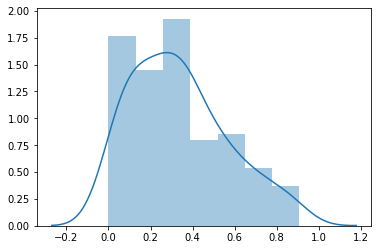

In [178]:
sns.distplot(s.numpy().ravel())

### With padding

In [24]:
num_sentences = 4000
bertEncoded = bertTokenizerFast.batch_encode_plus(sentences[:num_sentences],pad_to_max_length = True, max_length=512, return_tensors='pt', truncation=True).to(device)
gptEncoded = gptTokenizerFast.batch_encode_plus(sentences[:num_sentences],pad_to_max_length = True,  max_length=512, return_tensors='pt', truncation=True).to(device)
robertaEncoded = robertaTokenizer.batch_encode_plus(sentences[:num_sentences],pad_to_max_length = True, max_length=512, return_tensors='pt', truncation=True).to(device)

NameError: name 'bertTokenizerFast' is not defined

#### Check encoding alignment

In [ ]:
print(len(bertTokenizer.encode(sentences[1])))

304


In [ ]:
a = list(map(lambda x: len(x[1])-len(x[0]), zip(gptEncoded['input_ids'], bertEncoded['input_ids'])))

In [ ]:
def _sliceToBatches(encoded, batch_size):
    batches = []
    return [{k:v[i*batch_size:(1+i)*batch_size] for k,v in encoded.items()} 
                                    for i in range(int(np.ceil(len(encoded['input_ids'])/batch_size)))]

def headSimilarityWithPadding(modelA, modelB, encodedA_list, encodedB_list):
    res = None
    for encodedA, encodedB in tqdm(zip(encodedA_list, encodedB_list), total = len(encodedA_list)):
        N = len(encodedA['input_ids'][0])
        attentionsA = _getAttentionsReshaped(modelA(**encodedA))
        attentionsB = _getAttentionsReshaped(modelB(**encodedB)) # ( nLayers * nHeads, batch * N * N)
        denom = attentionsA.size(1) / N
        new_res = ((attentionsA @ attentionsB.transpose(0, 1))/denom).detach().numpy()
        if res is None:
            res=new_res
        else:
            res+=new_res
    
    return res/len(encodedA_list)

In [ ]:
sim_mat = headSimilarityWithPadding(robertaModel, bertModel,_sliceToBatches(robertaEncoded, 10), _sliceToBatches(bertEncoded, 10) )

## Predict Attention Heads

In [16]:
import torch
from torch.functional import F
from torch import nn
from torch.nn import Sequential
from torch.nn import Linear

In [11]:
largeBertTokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased', output_attentions = True,  cache_dir = cache_dir)
largeBertModel = AutoModel.from_pretrained('bert-large-uncased', output_attentions = True, cache_dir = cache_dir)

In [81]:
def _getSentLen(sent):
  assert(len(sent.shape) == 1)
  a = np.where(np.isnan(sent))[0]
  if len(a) == 0:
    return (sent.shape[0])
  else:
    return a[0]

from tqdm import tqdm_notebook

In [19]:
max_sent_len = 60
inputs_memmap = np.memmap(guy_folder + "/inputs.memmap", dtype = 'float32', shape = (100, 12, 12, max_sent_len, max_sent_len), mode = "w+")
target_memmap = np.memmap(guy_folder + "/target.memmap", dtype = 'float32', shape = (100, max_sent_len, max_sent_len), mode = "w+")

inputs_memmap[:] = None
target_memmap[:] = None

from tqdm import tqdm_notebook
t = tqdm_notebook(enumerate(encodedA_list))
for i, encodedA in t:
        inputs = _getAttentionsReshaped(bertModel(**encodedA), wordsToTokens = None, reshape = False).detach().numpy()
        target = _getAttentionsReshaped(largeBertModel(**encodedA), wordsToTokens = None, reshape = False)[10, 0].detach().numpy()
        
        sent_len = target.shape[0]
        inputs_memmap[i, :, :, :sent_len, :sent_len] = inputs
        target_memmap[i, :sent_len, :sent_len] = target



inputs_memmap.flush()
target_memmap.flush()


<ipython-input-19-86b3a2a9c14b>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(enumerate(encodedA_list))


In [83]:
class AttentionCombiner(nn.Module):
    def __init__(self):
        super(AttentionCombiner, self).__init__()
        self.n_heads = self.n_layers = 12
        self.n_total_heads = self.n_heads * self.n_layers
        self.weight = nn.Parameter(torch.ones((self.n_total_heads,1, 1))/100)
        
        
    def forward(self, x):
        x = x.view(self.n_total_heads, x.size(2), x.size(3))
        w = F.softmax(self.weight)
        # w /= w.sum(axis = 0, keepdims = True)
        x = (w * x).sum(axis = 0)
        return x #F.softmax(x, dim = -1)

In [84]:
class AttentionConverter(nn.Module):
    def __init__(self):
        super(AttentionConverter, self).__init__()
        self.combiner = AttentionCombiner()
        self.cnn = nn.Conv1d(1, 1, 3, padding = 1)

        nn.init.xavier_uniform_(self.cnn.weight)
    def forward(self, x):
        shape = x.shape
        x = self.cnn(x.view(-1, 1, x.size(-1)))
        x = x.view(*shape)
        x = self.combiner(x)
        return F.softmax(x.view(x.size(-1), x.size(-1)), dim = -1)

In [ ]:

attConv = AttentionConverter()
optimizer = torch.optim.Adam(attConv.parameters(), lr = 1)
criterion = nn.KLDivLoss(reduction = 'batchmean')
avg_loss = None
beta = 0.95
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 3, 
                                                       threshold = 1e-2,
                                                       min_lr = 1e-4,
                                                      verbose = True)

for i in range(100):
    print("Epoch " + str(i))
    t = tqdm(encodedA_list)
    for i, encodedA in enumerate(t):
      attConv.zero_grad()
      cur_inputs = inputs_memmap[i]
      cur_target = target_memmap[i]

      sent_len = _getSentLen(cur_target[0])
      inputs = torch.from_numpy(cur_inputs[:,:, :sent_len, :sent_len])
      target = torch.from_numpy(cur_target[ :sent_len, :sent_len]) 
      loss = criterion(torch.log(attConv(inputs)), target)
      if not avg_loss:
            avg_loss = loss.item()
      avg_loss = beta * avg_loss + (1-beta) * loss.item()
      t.set_postfix_str("Loss: " + str(avg_loss))
      loss.backward()
      optimizer.step()

    scheduler.step(avg_loss)
    t.clear()

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-83-86b061a03448>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  w = F.softmax(self.weight)
  2%|▏         | 2/100 [00:00<00:09, 10.05it/s, Loss: 0.7369477272033692]

Epoch 0


  1%|          | 1/100 [00:00<00:16,  6.09it/s, Loss: 0.5574845884044832]

Epoch 1


  3%|▎         | 3/100 [00:00<00:03, 26.88it/s, Loss: 0.5507944445590733]

Epoch 2


  0%|          | 0/100 [00:00<?, ?it/s, Loss: 0.5479231453656708]

Epoch 3


  1%|          | 1/100 [00:00<00:11,  8.35it/s, Loss: 0.5475673899141342]

Epoch 4


  0%|          | 0/100 [00:00<?, ?it/s, Loss: 0.5682125854739016]

Epoch 5


  0%|          | 0/100 [00:00<?, ?it/s, Loss: 0.5497624980293542]

Epoch 6


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch     7: reducing learning rate of group 0 to 5.0000e-01.
Epoch 7


  0%|          | 0/100 [00:00<?, ?it/s, Loss: 0.5510568442037124]

Epoch 8


  2%|▏         | 2/100 [00:00<00:06, 15.25it/s, Loss: 0.5434966996569788]

Epoch 9


  0%|          | 0/100 [00:00<?, ?it/s, Loss: 0.5474983564940133]

Epoch 10


  3%|▎         | 3/100 [00:00<00:04, 20.88it/s, Loss: 0.5449971921985703]

Epoch    11: reducing learning rate of group 0 to 2.5000e-01.
Epoch 11


 78%|███████▊  | 78/100 [00:14<00:06,  3.42it/s, Loss: 0.543146003252798] 

### Old

In [29]:
optimizer = torch.optim.Adam(attConv.parameters(), lr = 1e-2)
from tqdm import tqdm_notebook
criterion = nn.KLDivLoss(reduction = 'batchmean')
for i in range(5):
  print("Epoch " + str(i))
  t = tqdm_notebook(encodedA_list)

  for encodedA in t:
          attConv.zero_grad()
          inputs = _getAttentionsReshaped(bertModel(**encodedA), wordsToTokens = None, reshape = False)
          target = _getAttentionsReshaped(largeBertModel(**encodedA), wordsToTokens = None, reshape = False)[10, 0] 
          shape = target.shape
          loss = criterion(torch.log(attConv(inputs)), target)
          t.set_postfix_str("Loss: " + str(loss.item()))
          loss.backward()
          optimizer.step()

Epoch 0


<ipython-input-29-20c3bd58a35b>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(encodedA_list)


<ipython-input-17-86b061a03448>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  w = F.softmax(self.weight)


KeyboardInterrupt: 